## UMI preprocessing:

In [1]:
import scprep as sp
import pandas as pd
import umap

In [2]:
#sp.io.download.download_google_drive('1QGkqL_FF7iveR1TLZ8HJKBANOmugBxlm', 'retinal_bipolar.zip')
#sp.io.download.unzip('retinal_bipolar.zip')
data = sp.io.load_mtx('retinal_bipolar/matrix.mtx', cell_names='retinal_bipolar/cell_names.tsv', gene_names='retinal_bipolar/gene_names.tsv', sparse=True)
metadata = sp.io.load_tsv('retinal_bipolar/metadata.tsv')

/home/vivian/.local/lib/python3.8/site-packages/scprep/sanitize.py:49: RuntimeWarning: Data is not numeric. Many scprep functions will not work.
  warnings.warn(


In [3]:
PERC_LO = 20
PERC_HI = 80
RARE_GEN = 10
MIN_GENES = 200
NPCS = 100
NN = 50
MIN_DIST = 0.8

In [4]:
# Library size filtering
data, metadata = sp.filter.filter_library_size(data, metadata, percentile=(PERC_LO, PERC_HI))
# Library size normalization
data = sp.normalize.library_size_normalize(data)
# Mitochondrial DNA filtering
data, metadata = sp.filter.filter_gene_set_expression(data, metadata, starts_with='mt-', keep_cells='below', percentile=PERC_HI)
# Remove rarely occurring genes
data = sp.filter.filter_rare_genes(data, min_cells=RARE_GEN)
# Perform square root transform
data = sp.transform.sqrt(data)
# Remove unlabelled cells
data, metadata = sp.select.select_rows(data, metadata, idx=metadata['CELLTYPE'] != '-1')

In [5]:
# Perform PCA
data_pca = sp.reduce.pca(data, n_components=NPCS, method='dense')

In [6]:
# Compute UMAP
umap_op = umap.UMAP(n_neighbors=NN, min_dist=MIN_DIST)
data_umap = umap_op.fit_transform(data_pca)
data_umap = pd.DataFrame(data_umap, index = data.index)

## A simple visualisation using SCPrep:

<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

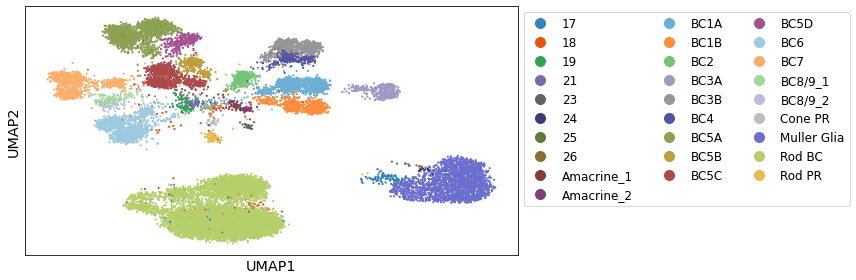

In [7]:
sp.plot.scatter2d(data_umap, c=metadata['CELLTYPE'], figsize=(12,4), legend_anchor=(1,1), ticks=False, label_prefix='UMAP')

## How the output for visualization will look like:

In [18]:
observation_data = pd.concat([data_umap, metadata[['SUB-CLUSTER']]], axis=1)
observation_data.rename(columns={0: 'x', 1: 'y', 'SUB-CLUSTER': 'cluster'}, inplace=True)
observation_data.to_csv('retinal_bipolar_viz/umap_data')

In [13]:
mapping = metadata.drop_duplicates().sort_values('CLUSTER')
mapping.reset_index(drop=True, inplace=True)
mapping.to_csv('retinal_bipolar_viz/meta_data')